# EXTRACT TEXT FROM MEMEs WITH PYTHON AND TESSERACT
### A tutorial with a starting point pipeline to tackle the extraction of text from memes 

Hello everyone! I'm Egon, and I'm a data scientist.
While me and my collegue Lorenzo Baiocco were working on a project on multi-media sentiment analysis on twitter data (not the story that you'll hear! At least today...), we realized that we needed a simple way to extract text from images (with a focus on reaction pic formatted as meme) because we felt that it was carrying a strong part of the sentiment information.

We decided to extract text using [tesseract ocr](https://github.com/tesseract-ocr/tessdoc), because after a little bit of research we found it to be the best free available tool.
Tesseract it's very easy to install and use, and it provides clean APIs to exploit is power in python. 
The setup of the envirnoment in which we will code it's very easy, we only need to install the last version of tesseract from the link provided above and import a bunch of classic image-processing libraries.

Hello everyone! I'm Egon, and I'm a data scientist. 
I decided to write this article, in collaboration with my colleague Lorenzo Baiocco, to share useful information and best practices in extracting text from images using Google Tesseract OCR. 
We are working on a project aimed to classify tweets through a "multi-modal" sentiment analysis approach. Exctracting text information from an image can obviously help to make a correct sentiment classification. This method is focused on reaction pics formatted as MEME, the most common reaction pic that can be found on social medias.
Currently (Nov 2020), the state of the art in text extraction through OCR methods is represented by Google Tesseract OCR, which is the most used open-source software to deal with this task.

tesseract is easy to install (following this link) and use in a python environment, through the pytesseract library.

The environment used for this article is the following:
- Python 3.X 
- Latest Tesseract release installed
- Pytesseract
- Pillow
- Matplotlib
- OpenCV
- Numpy




In [2]:
#to load and process images
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract

#change this path if you install pytesseract in another folder:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' 

We are ready to extract some text! Let's load a dummy meme to avoid in any manner to break copyright (anyway, this meme has been done with [imageflip](https://imgflip.com/memegenerator))

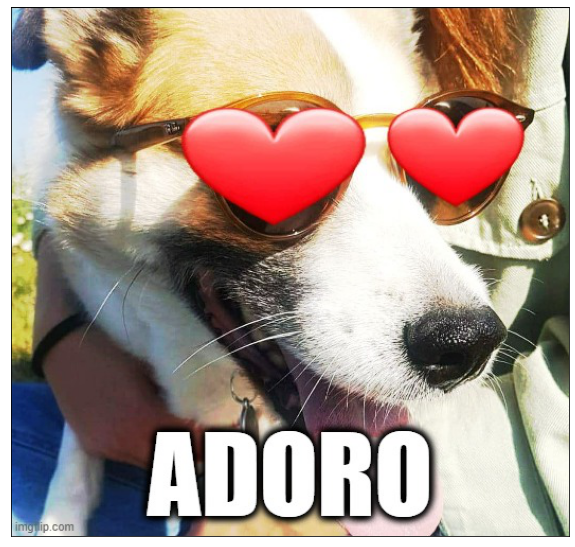

In [3]:
im = np.array(Image.open(r'../meme sissi/sissi4.jpg'))
plt.figure(figsize=(10,10))
#plt.title('PLAIN IMAGE')
plt.imshow(im); plt.xticks([]); plt.yticks([])
plt.savefig('img1.png',bbox_inches='tight')


To search for text is as easy as it goes:

In [4]:
text = pytesseract.image_to_string(im)
print(text.replace('\n', ' '))

And the result is..."a a TTY SHE aT aN Sa ithe  Pet". 
Woooah there is something going on. Tesseract is not working. 
The problem is that Tesseract is optimized to recognize text in typical text documents, so it con be difficult recognize text within the image without preprocessing it. The Tesseract [documentation](https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html) provides a lot of ways to enhance the quality of our images.
After some fine tuning, we found a very clean method that worked perfectly on the subset of data that we used. Before diving into it, it's important for you to know that, altough these operation worked very good for our data, there are a couple of parameters that were tuned empirically. If you have a dataset that is different from the one that we used, it could be helpful to tune them a little bit.


# CLEANING DELL'IMMAGINE

## BILATERAL FILTER

The first function that we applied to our image is bilateral filtering. If you want to understand deeply how it works, there is a nice tutorial on [opencv](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html) site, and you can find the description of the parameters [here](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed).

In a nutshell, this filter helps to remove the noise, but, in contrast with other filters, preserves edges instead of blurring them. This operation is performed by excluding from the blurring of a point the neighbors that does not presente similiar intensities. With the chosen parameters, the difference from the other image is not strongly percieveble, however, it led to better perfomance.

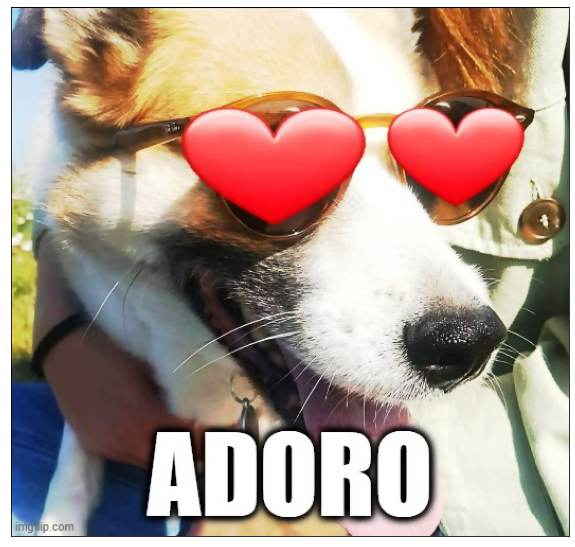

In [5]:
im= cv2.bilateralFilter(im,5, 55,60)
plt.figure(figsize=(10,10))
#plt.title('BILATERAL FILTER')
plt.imshow(im); plt.xticks([]); plt.yticks([])
plt.savefig('img2.png',bbox_inches='tight')

# SPOSTARE DA RGB A SCALA DI GRIGI

The second operation it's pretty clear: we project our RGB images in grayscale.

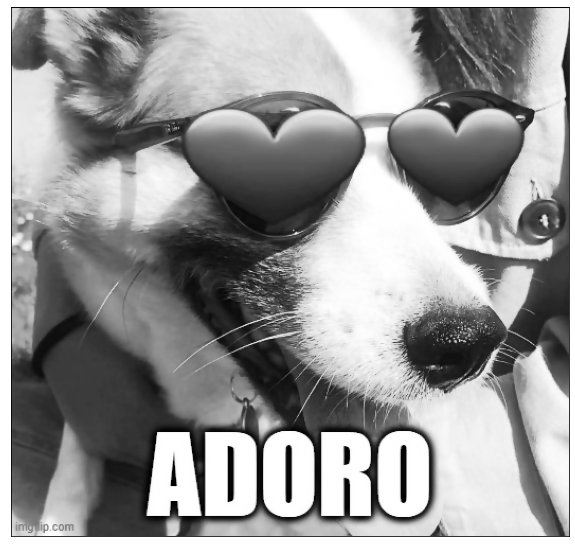

In [6]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
#plt.title('GRAYSCALE IMAGE')
plt.imshow(im, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.savefig('img3.png',bbox_inches='tight')

## BINARIZATION AND INVERSION

The last trasformation is the binarization. For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to 255. 
Since we have white text, we want to black out everything is not almost perfectily white (not exactly perfect since usually text is not "255-white". We found that 240 was a treshold that could do the work.
Since tesseract is trained to recognize black text, we also need to invert the colors. 
The function thresold from open cv can do the two operation jointly, by selecting the inverted binarization.

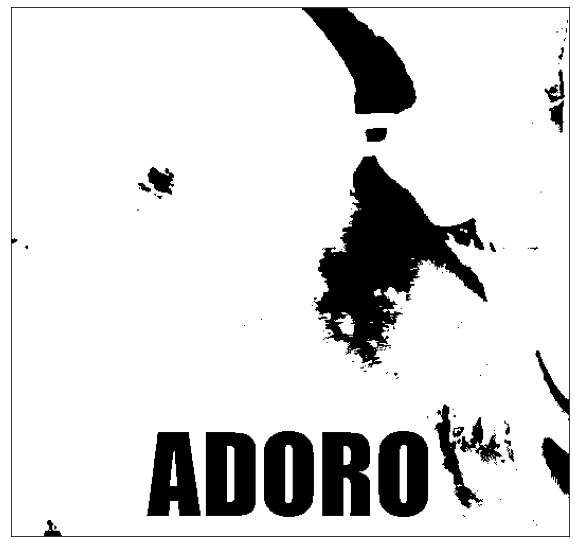

In [7]:
_, im = cv2.threshold(im, 240, 255, 1) 
plt.figure(figsize=(10,10))
#plt.title('BINARIZED IMAGE')
plt.imshow(im, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.savefig('img4.png',bbox_inches='tight')

This is the input that we want! Let's put everything into a function:

In [8]:
def preprocess_final(im):
    im= cv2.bilateralFilter(im,5, 55,60)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 240, 255, 1)
    return im

## CONFIG TESSERACT

Before running our tesseract on the final image, we can tune it a little bit to optimize the configuration.

There are three oem(OCR Engine modes):
- 0    Legacy engine only.
- 1    Neural nets LSTM engine only.
- 2    Legacy + LSTM engines.
- **3    Default, based on what is available.**


And thirtheen psm(Page segmentation modes):
- 0    Orientation and script detection (OSD) only.
- 1    Automatic page segmentation with OSD.
- 2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
- 3    Fully automatic page segmentation, but no OSD. (Default)
- 4    Assume a single column of text of variable sizes.
- 5    Assume a single uniform block of vertically aligned text.
- 6    Assume a single uniform block of text.
- 7    Treat the image as a single text line.
- 8    Treat the image as a single word.
- 9    Treat the image as a single word in a circle.
- 10    Treat the image as a single character.
- **11    Sparse text. Find as much text as possible in no particular order.**
- 12    Sparse text with OSD.
- 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

In bald what we found to work better.
Furthermore, we decided to give tesseract a whitelist of acceptable character, since we preferred to have only the capital letters in orther to avoid small text and strange charachters that are sometimes found by tesseract.

In [19]:

custom_config = r"--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ"



In [20]:
img=np.array(Image.open(r'../meme sissi/sissi4.jpg'))
im=preprocess_final(img)
text = pytesseract.image_to_string(im, lang='ita', config=custom_config)
print(text.replace('\n', ''))

ADORO


Et voilà! Now everything works perfectly. 

# CONCLUSION

In this brief article, we defined a simple pipeline.
The definition of the pipeline, was driven by our precise scope. If you need something similiar but different, you obviously consider to modify it. For example, if you need also the black text that is sometimes in the upper part of memes, you could considere a double stream and a final join of the result.
Anyway, we hope that this simple procedure can help you to get started!